## Run the first 4 cells to import data and create training and testing set

In [25]:
import numpy as np
import h5py
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import SimpleRNN,LSTM, Dense, Activation
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import StandardScaler
from UtilNNDL import *

In [26]:
"""
#file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
file_path = '/home/kunal/Desktop/FinalProject/datasets/A01T_slice.mat'

A01T = h5py.File(file_path,'r')
data = np.copy(A01T['image'])
data = np.transpose(data,(0,2,1))
data = data[:,:,:22]
labels = np.copy(A01T['type'])
labels = labels[0,0:data.shape[0]:1]
labels = np.asarray(labels, dtype=np.int32)

a = data[:56]
b = data[57:]
data = np.vstack((a,b))
a = labels[:56]
b = labels[57:]
labels = np.hstack((a,b))
#enc = OneHotEncoder()
#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()
enc_labels = to_categorical(labels-769, num_classes=4)
print(enc_labels)

#scaler = StandardScaler()
#data = scaler.fit_transform(data,enc_labels)
"""

"\n#file_path = '/home/carla/Downloads/project_datasets/project_datasets/'\nfile_path = '/home/kunal/Desktop/FinalProject/datasets/A01T_slice.mat'\n\nA01T = h5py.File(file_path,'r')\ndata = np.copy(A01T['image'])\ndata = np.transpose(data,(0,2,1))\ndata = data[:,:,:22]\nlabels = np.copy(A01T['type'])\nlabels = labels[0,0:data.shape[0]:1]\nlabels = np.asarray(labels, dtype=np.int32)\n\na = data[:56]\nb = data[57:]\ndata = np.vstack((a,b))\na = labels[:56]\nb = labels[57:]\nlabels = np.hstack((a,b))\n#enc = OneHotEncoder()\n#enc_labels = enc.fit_transform(labels.reshape(-1,1)).toarray()\nenc_labels = to_categorical(labels-769, num_classes=4)\nprint(enc_labels)\n\n#scaler = StandardScaler()\n#data = scaler.fit_transform(data,enc_labels)\n"

In [27]:
"""
bs, t, f = data.shape
np.random.seed(42)
shuffle = np.random.choice(bs,bs,replace=False)

train_samples = 237
train_data = data[shuffle[:train_samples],:,:]
train_labels = enc_labels[shuffle[:train_samples]]
test_data = data[shuffle[train_samples:],:,:]
test_labels =enc_labels[shuffle[train_samples:]]

train_data = np.transpose(train_data,(0,2,1))
test_data = np.transpose(test_data,(0,2,1))

train_data,train_labels = create_window_data(train_data,train_labels)
test_data,test_labels = create_window_data(test_data,test_labels)

train_data = np.transpose(train_data,(0,2,1))
test_data = np.transpose(test_data,(0,2,1))

bs, t, f = train_data.shape
"""

'\nbs, t, f = data.shape\nnp.random.seed(42)\nshuffle = np.random.choice(bs,bs,replace=False)\n\ntrain_samples = 237\ntrain_data = data[shuffle[:train_samples],:,:]\ntrain_labels = enc_labels[shuffle[:train_samples]]\ntest_data = data[shuffle[train_samples:],:,:]\ntest_labels =enc_labels[shuffle[train_samples:]]\n\ntrain_data = np.transpose(train_data,(0,2,1))\ntest_data = np.transpose(test_data,(0,2,1))\n\ntrain_data,train_labels = create_window_data(train_data,train_labels)\ntest_data,test_labels = create_window_data(test_data,test_labels)\n\ntrain_data = np.transpose(train_data,(0,2,1))\ntest_data = np.transpose(test_data,(0,2,1))\n\nbs, t, f = train_data.shape\n'

In [28]:
#Prepare the data by taking out nans and dividing into test and train
file_path = '/home/carla/Downloads/project_datasets/project_datasets/'
#file_path = '/home/kunal/Desktop/FinalProject/datasets/'
train_data, test_data, train_labels, test_labels = prepare_data(file_path, 
                                                                num_test_samples = 50, 
                                                                verbose= False, 
                                                                return_all=True,
                                                                num_files =1)
print train_data.shape
print train_labels.shape
print test_data.shape
print test_labels.shape

(237, 22, 1000)
(237, 4)
(50, 22, 1000)
(50, 4)


In [29]:
#assist numerical stability
train_data = train_data*(1e6)
test_data = test_data*(1e6)

In [30]:
#Bandpass filter the data
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2)
print train_data.shape
print test_data.shape
for i,a in enumerate(train_data):
    train_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)
for i,a in enumerate(test_data):
    test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
print train_data.shape
print test_data.shape

(237, 1000, 22)
(50, 1000, 22)
(237, 1000, 22)
(50, 1000, 22)


In [31]:
#Standardize the data
for i,a in enumerate(train_data):
    train_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
for i,a in enumerate(test_data):
    test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)
train_data = train_data.swapaxes(1,2)
test_data = test_data.swapaxes(1,2) 
print train_data.shape
print test_data.shape

(237, 22, 1000)
(50, 22, 1000)


In [32]:
#Augment the data into a bigger set by windowing
train_data_sliced, train_labels_sliced = create_window_data(train_data, train_labels, windows=10,window_size=750)
test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10,window_size=750)

train_data_sliced = train_data_sliced.swapaxes(1,2)
test_data_sliced = test_data_sliced.swapaxes(1,2) 

bs,t,f = train_data_sliced.shape

print train_data_sliced.shape
print train_labels_sliced.shape
print test_data_sliced.shape
print test_labels_sliced.shape

(2370, 750, 22)
(2370, 4)
(500, 750, 22)
(500, 4)


# Everything from this point down is Testing

In [11]:
# Modify test data to run model on another subject
_, test_data_orig, _, test_labels_orig = prepare_data(file_path, 
                                            num_test_samples=50, 
                                            verbose=False, 
                                            return_all=False,
                                            num_files=9)

In [12]:
test_data_all = []
test_labels_all = []
for n in range(1,10):
    test_data = test_data_orig['A0{}T'.format(n)]
    test_labels = test_labels_orig['A0{}T'.format(n)]
    #print test_data.shape
    #print test_labels.shape

    #assist numerical stability
    test_data = test_data*(1e6)
    test_data = test_data.swapaxes(1,2)
    for i,a in enumerate(test_data):
        test_data[i] = bandpass_cnt(a, 4, 38, 250, filt_order=3)    
    #print test_data.shape

    #standardize
    for i,a in enumerate(test_data):
        test_data[i] = exponential_running_standardize(a, factor_new=0.001, init_block_size=1000, eps=1e-4)

    test_data = test_data.swapaxes(1,2) 
    test_data_sliced, test_labels_sliced = create_window_data(test_data, test_labels, windows=10)

    test_data_sliced = test_data_sliced[:500,:]
    test_labels_sliced = test_labels_sliced[:500,:]
    
    test_data_sliced = test_data_sliced.swapaxes(1,2)
    
    #print test_data_sliced.shape
    #print test_labels_sliced.shape 
    
    test_data_all.append(test_data_sliced)
    test_labels_all.append(test_labels_sliced)

In [18]:
model = Sequential([
    LSTM(100, input_shape=(t,f)),
    Dense(32),
    Activation('relu'),
    #Dense(64),
    #Activation('relu'),
    Dense(32),
    Activation('relu'),
    Dense(4),
    Activation('softmax'),
])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data,train_labels,epochs=15,validation_split=0.25,batch_size=32,verbose=0)
test_score = model.evaluate(test_data, test_labels, batch_size=32)

print(test_score)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

KeyboardInterrupt: 

## Modified VGGnet for this type of data

Modified VGG net to handle our input i.e. replace 2D with 1D, etc.(need to check dimensions and might need to transpose input to original shape)

Original VGGnet implementation can be found at hte address below

Subject 1
500/500 [==============================] - 0s 608us/step
Test Score: [1.1591282806396483, 0.41999999904632568]
Subject 2
500/500 [==============================] - 0s 107us/step
Test Score: [1.5540989713668822, 0.26200000017881392]
Subject 3
500/500 [==============================] - 0s 115us/step
Test Score: [1.1912931404113769, 0.47800000143051147]
Subject 4
500/500 [==============================] - 0s 112us/step
Test Score: [1.6169553489685058, 0.2960000002384186]
Subject 5
500/500 [==============================] - 0s 124us/step
Test Score: [1.5434520225524901, 0.25800000002980233]
Subject 6
500/500 [==============================] - 0s 134us/step
Test Score: [1.6908332347869872, 0.27600000002980229]
Subject 7
500/500 [==============================] - 0s 129us/step
Test Score: [1.5334240589141845, 0.28800000035762785]
Subject 8
500/500 [==============================] - 0s 116us/step
Test Score: [1.483209119796753, 0.3440000000298023]
Subject 9
500/500 [================

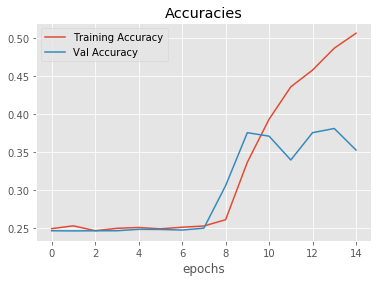

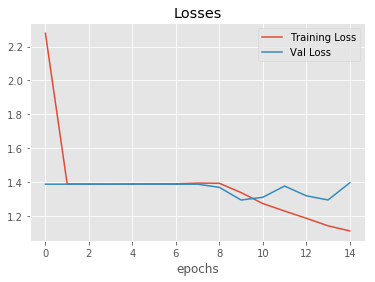

In [17]:
### VGGnet
# https://keras.io/getting-started/sequential-model-guide/#examples

import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
#norm_test = np.transpose((-np.mean(test_data,axis=2)+np.transpose(test_data,(2,0,1)))/np.std(test_data,axis=2),(1,2,0))

model = Sequential()
#model.add(LSTM(100, input_shape=(t,f)))
model.add(Conv1D(32, 4, activation='relu',input_shape=(t,f)))             #Originally 32 each
model.add(BatchNormalization())
model.add(Conv1D(32, 4, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Conv1D(64, 4, activation='relu'))                                    #Originally 64 each
model.add(BatchNormalization())
model.add(Conv1D(64, 4, activation='relu'))
model.add(MaxPooling1D())
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=0)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)
print(test_score)
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
test_predict = model.predict(test_data_sliced, batch_size=16)

#conf = []
#test_score = []

#for i in range(9):
#    print "Subject {}".format(i+1)
#    test_score_i = model.evaluate(test_data_all[i], test_labels_all[i], batch_size=64)
#    print "Test Score: {}".format(test_score_i)
#    test_predict = model.predict(test_data_all[i], batch_size=16)
#    cm = confusion_matrix(np.argmax(test_labels_all[i],axis=1),np.argmax(test_predict,axis=1))
#    conf.append(cm)
#    test_score.append(test_score_i)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

In [18]:
#np.save('Best Models/Variables/VGG_hist_All',hist.history)
#np.save('Best Models/Variables/VGG_testacc_All',test_score)
#np.save('Best Models/Variables/VGG_conf_All',conf)

Simple RNN model

500/500 [==============================] - 1s 1ms/step
[1.4065807809829711, 0.25600000023841857]


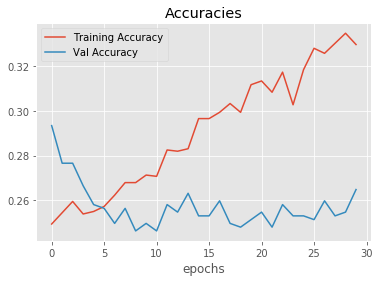

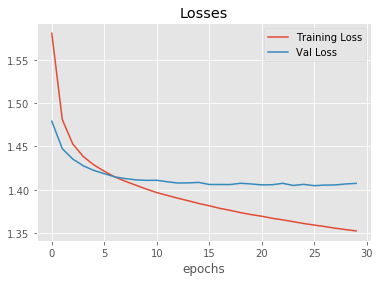

In [12]:
model = Sequential([
    SimpleRNN(64, input_shape=(t,f)),
    #Dense(32),
    #BatchNormalization(),
    #Activation('relu'),
    Dense(4),
    Activation('softmax'),
])

model.compile(optimizer = 'sgd',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data_sliced,train_labels_sliced,epochs=30,validation_split=0.25,batch_size=64,verbose=0)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=32)

print(test_score)
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

# CHRONONET PAPER

## C-RNN implementation (Figure 1b)

Train on 1777 samples, validate on 593 samples
Epoch 1/10
1777/1777 [==============================] - 17s 10ms/step - loss: 1.3835 - acc: 0.2673 - val_loss: 1.3483 - val_acc: 0.3626
Epoch 2/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.3011 - acc: 0.3675 - val_loss: 1.3396 - val_acc: 0.3086
Epoch 3/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.2308 - acc: 0.4142 - val_loss: 1.1744 - val_acc: 0.4401
Epoch 4/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.1597 - acc: 0.4474 - val_loss: 1.1623 - val_acc: 0.4081
Epoch 5/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.1090 - acc: 0.4615 - val_loss: 1.0412 - val_acc: 0.4992
Epoch 6/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.0594 - acc: 0.5048 - val_loss: 1.0397 - val_acc: 0.5126
Epoch 7/10
1777/1777 [==============================] - 7s 4ms/step - loss: 1.0264 - acc: 0.5144 - val_loss: 1.1548 - val_acc: 0.4469
Epoch 8/10
17

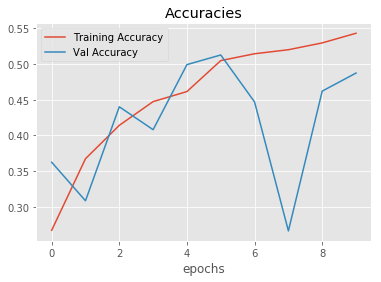

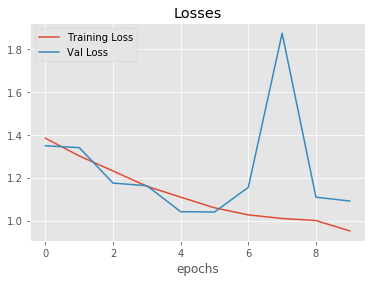

In [67]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU
from keras.optimizers import SGD
from keras.initializers import glorot_normal


model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(Conv1D(32, 4, strides=2,activation='relu'))

#model.add(Flatten())

model.add(GRU(32,activation='tanh',return_sequences=True,kernel_initializer=glorot_normal()))
model.add(GRU(32,activation='tanh',return_sequences=True,kernel_initializer=glorot_normal()))
model.add(GRU(32,activation='tanh',return_sequences=True,kernel_initializer=glorot_normal()))
model.add(GRU(32,activation='tanh',kernel_initializer=glorot_normal()))

#model.add(Dense(64,activation = 'relu'))
#model.add(Dense(32,activation = 'relu'))
model.add(Dense(4, activation='softmax'))

#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd)

#model.add()

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

hist = model.fit(train_data_sliced,train_labels_sliced,epochs=10,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced,test_labels_sliced, batch_size=64)
print(test_score)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

Implementation of Figure 1b but adding regularization structures like that found in VGGnet

Train on 15810 samples, validate on 5270 samples
Epoch 1/15
15810/15810 [==============================] - 34s 2ms/step - loss: 1.3592 - acc: 0.2988 - val_loss: 1.4715 - val_acc: 0.2825
Epoch 2/15
15810/15810 [==============================] - 34s 2ms/step - loss: 1.2914 - acc: 0.3732 - val_loss: 1.3956 - val_acc: 0.3118
Epoch 3/15
15810/15810 [==============================] - 33s 2ms/step - loss: 1.2358 - acc: 0.4084 - val_loss: 1.4977 - val_acc: 0.3359
Epoch 4/15
15810/15810 [==============================] - 33s 2ms/step - loss: 1.1911 - acc: 0.4300 - val_loss: 1.5600 - val_acc: 0.2951
Epoch 5/15
15810/15810 [==============================] - 33s 2ms/step - loss: 1.1451 - acc: 0.4541 - val_loss: 1.4569 - val_acc: 0.3630
Epoch 6/15
15810/15810 [==============================] - 33s 2ms/step - loss: 1.1126 - acc: 0.4682 - val_loss: 2.1275 - val_acc: 0.2863
Epoch 7/15
15810/15810 [==============================] - 33s 2ms/step - loss: 1.0799 - acc: 0.4870 - val_loss: 1.7322 - val_acc:

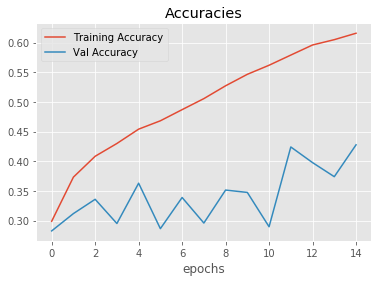

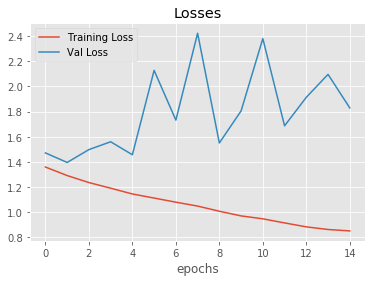

In [26]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(MaxPooling1D())                                  #From VGGnet
model.add(Dropout(0.25))                                   #From VGGnet
#model.add(Flatten())

model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))
model.add(GRU(32,activation='tanh',return_sequences=True))  #removed because of overfitting problem to small sample size
model.add(GRU(32,activation='tanh'))

#model.add(Dense(256, activation='relu'))                   #From VGGnet, but makes model suck
#model.add(Dropout(0.5))                                    #From VGGnet, but makes model suck
model.add(Dense(64, activation = 'relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation = 'relu'))
model.add(Dense(16, activation = 'relu'))
model.add(Dense(4, activation='softmax'))

# From VGGnet, works well for some reason
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=16)
print(test_score)
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
test_predict = model.predict(test_data_sliced, batch_size=16)

#conf = []
#test_score = []

#for i in range(9):
#    print "Subject {}".format(i+1)
#    test_score_i = model.evaluate(test_data_all[i], test_labels_all[i], batch_size=64)
#    print "Test Score: {}".format(test_score_i)
#    test_predict = model.predict(test_data_all[i], batch_size=16)
#    cm = confusion_matrix(np.argmax(test_labels_all[i],axis=1),np.argmax(test_predict,axis=1))
#    conf.append(cm)
#    test_score.append(test_score_i)
    
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


In [27]:
#np.save('Best Models/Variables/CRNNGRU_hist_All',hist.history)
#np.save('Best Models/Variables/CRNNGRU_testacc_All',test_score)
#np.save('Best Models/Variables/CRNNGRU_conf_All',conf)

Replaced GRU with LSTM

Train on 15810 samples, validate on 5270 samples
Epoch 1/15
15810/15810 [==============================] - 42s 3ms/step - loss: 1.3210 - acc: 0.3512 - val_loss: 1.4728 - val_acc: 0.3271
Epoch 2/15
15810/15810 [==============================] - 41s 3ms/step - loss: 1.2052 - acc: 0.4462 - val_loss: 1.3615 - val_acc: 0.4213
Epoch 3/15
15810/15810 [==============================] - 40s 3ms/step - loss: 1.1132 - acc: 0.4927 - val_loss: 1.1989 - val_acc: 0.4991
Epoch 4/15
15810/15810 [==============================] - 40s 3ms/step - loss: 1.0513 - acc: 0.5247 - val_loss: 1.3815 - val_acc: 0.4349
Epoch 5/15
15810/15810 [==============================] - 40s 3ms/step - loss: 0.9946 - acc: 0.5541 - val_loss: 1.3685 - val_acc: 0.4899
Epoch 6/15
15810/15810 [==============================] - 40s 3ms/step - loss: 0.9448 - acc: 0.5859 - val_loss: 1.3974 - val_acc: 0.4717
Epoch 7/15
15810/15810 [==============================] - 40s 3ms/step - loss: 0.9037 - acc: 0.6025 - val_loss: 1.4297 - val_acc:

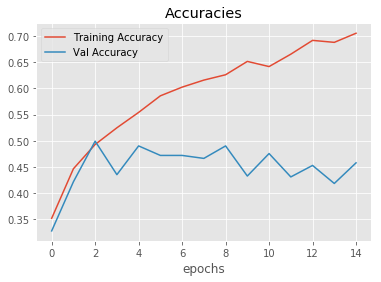

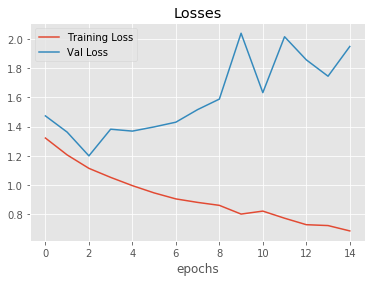

In [28]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPooling1D, BatchNormalization,GRU,LSTM
from keras.optimizers import SGD

#norm_train = np.transpose((-np.mean(train_data,axis=2)+np.transpose(train_data,(2,0,1)))/np.std(train_data,axis=2),(1,2,0))
model = Sequential()

model.add(Conv1D(32, 4, strides=2,activation='relu',input_shape=(t,f)))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(BatchNormalization())                            #From VGGnet
model.add(Conv1D(32, 4, strides=2,activation='relu'))
model.add(MaxPooling1D())                                  #From VGGnet
model.add(Dropout(0.25))                                   #From VGGnet
#model.add(Flatten())

model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh',return_sequences=True))
model.add(LSTM(32,activation='tanh'))

#model.add(Dense(256, activation='relu'))                   #From VGGnet, but makes model suck
#model.add(Dropout(0.5))                                    #From VGGnet, but makes model suck
model.add(Dense(4, activation='softmax'))

# From VGGnet, works well for some reason
#sgd = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
#model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)
print "Test Results are ", test_score
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
test_predict = model.predict(test_data_sliced, batch_size=16)

#conf = []
#test_score = []

#for i in range(9):
#    print "Subject {}".format(i+1)
#    test_score_i = model.evaluate(test_data_all[i], test_labels_all[i], batch_size=64)
#    print "Test Score: {}".format(test_score_i)
#    test_predict = model.predict(test_data_all[i], batch_size=16)
#    cm = confusion_matrix(np.argmax(test_labels_all[i],axis=1),np.argmax(test_predict,axis=1))
#    conf.append(cm)
#    test_score.append(test_score_i)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


In [29]:
#np.save('Best Models/Variables/CRNNLSTM_hist_All',hist.history)
#np.save('Best Models/Variables/CRNNLSTM_testacc_All',test_score)
#np.save('Best Models/Variables/CRNNLSTM_conf_All',conf)

## IC-RNN

Train on 1777 samples, validate on 593 samples
Epoch 1/15
1777/1777 [==============================] - 19s 10ms/step - loss: 1.3920 - acc: 0.2876 - val_loss: 1.3459 - val_acc: 0.3440
Epoch 2/15
1777/1777 [==============================] - 8s 4ms/step - loss: 1.2776 - acc: 0.4012 - val_loss: 1.1440 - val_acc: 0.4857
Epoch 3/15
1777/1777 [==============================] - 8s 4ms/step - loss: 1.0378 - acc: 0.5194 - val_loss: 1.0521 - val_acc: 0.5177
Epoch 4/15
1777/1777 [==============================] - 8s 4ms/step - loss: 1.0068 - acc: 0.5279 - val_loss: 1.0073 - val_acc: 0.5329
Epoch 5/15
1777/1777 [==============================] - 8s 4ms/step - loss: 0.9075 - acc: 0.5763 - val_loss: 1.0471 - val_acc: 0.4806
Epoch 6/15
1777/1777 [==============================] - 8s 4ms/step - loss: 0.8892 - acc: 0.5763 - val_loss: 0.9707 - val_acc: 0.5160
Epoch 7/15
1777/1777 [==============================] - 8s 4ms/step - loss: 0.8196 - acc: 0.6213 - val_loss: 1.2897 - val_acc: 0.4992
Epoch 8/15
17

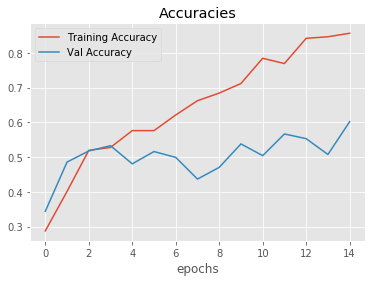

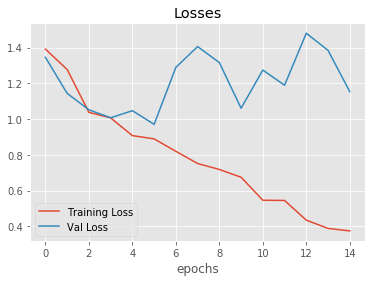

In [70]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)


x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh',return_sequences=True)(x)
x = GRU(32,activation='tanh')(x)


predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)
print "Test Results are ", test_score

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


### IC-RNN Testing

Subject 1
500/500 [==============================] - 0s 917us/step
Test Score: [1.0620317478179933, 0.57200000190734868]
Subject 2
500/500 [==============================] - 0s 814us/step
Test Score: [1.7051339035034179, 0.34400000017881394]
Subject 3
500/500 [==============================] - 0s 811us/step
Test Score: [1.4872502994537353, 0.46600000005960462]
Subject 4
500/500 [==============================] - 0s 854us/step
Test Score: [1.660764591217041, 0.37600000095367431]
Subject 5
500/500 [==============================] - 0s 883us/step
Test Score: [1.8736546630859374, 0.27400000017881393]
Subject 6
500/500 [==============================] - 0s 806us/step
Test Score: [2.0726626338958742, 0.2980000001192093]
Subject 7
500/500 [==============================] - 0s 882us/step
Test Score: [1.6862463340759277, 0.38400000035762788]
Subject 8
500/500 [==============================] - 0s 836us/step
Test Score: [1.6732919826507568, 0.39000000000000001]
Subject 9
500/500 [===============

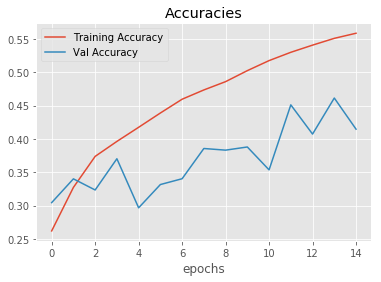

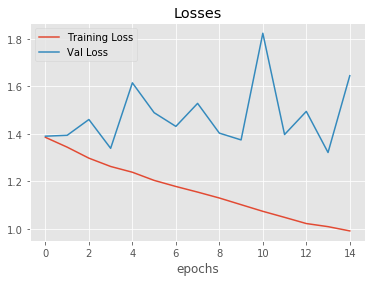

In [19]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,Bidirectional
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(x)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)


# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
#tower4 = MaxPooling1D()(x)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.5)(x)


x = (GRU(32,activation='tanh',return_sequences=True))(x)
x = (GRU(32,activation='tanh',return_sequences=True))(x)
x = (GRU(32,activation='tanh',return_sequences=True))(x)
x = (GRU(32,activation='tanh'))(x)


predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=15,validation_split=0.25,batch_size=64,verbose=0)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)
print "Test Results are ", test_score
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
test_predict = model.predict(test_data_sliced, batch_size=16)

#conf = []
#test_score = []

#for i in range(9):
#    print "Subject {}".format(i+1)
#    test_score_i = model.evaluate(test_data_all[i], test_labels_all[i], batch_size=64)
#    print "Test Score: {}".format(test_score_i)
#    test_predict = model.predict(test_data_all[i], batch_size=16)
#    cm = confusion_matrix(np.argmax(test_labels_all[i],axis=1),np.argmax(test_predict,axis=1))
#    conf.append(cm)
#    test_score.append(test_score_i)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


In [20]:
#np.save('Best Models/Variables/ICRNN_hist_All',hist.history)
#np.save('Best Models/Variables/ICRNN_testacc_All',test_score)
#np.save('Best Models/Variables/ICRNN_conf_All',conf)

## C-DRNN

Train on 1777 samples, validate on 593 samples
Epoch 1/20
1777/1777 [==============================] - 30s 17ms/step - loss: 1.3788 - acc: 0.2780 - val_loss: 1.3228 - val_acc: 0.3676
Epoch 2/20
1777/1777 [==============================] - 15s 8ms/step - loss: 1.2343 - acc: 0.4114 - val_loss: 1.2274 - val_acc: 0.4047
Epoch 3/20
1777/1777 [==============================] - 15s 8ms/step - loss: 1.1532 - acc: 0.4598 - val_loss: 1.0572 - val_acc: 0.4840
Epoch 4/20
1777/1777 [==============================] - 15s 8ms/step - loss: 1.0506 - acc: 0.5020 - val_loss: 0.9643 - val_acc: 0.5565
Epoch 5/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.9803 - acc: 0.5290 - val_loss: 0.9630 - val_acc: 0.5379
Epoch 6/20
1777/1777 [==============================] - 15s 9ms/step - loss: 0.9677 - acc: 0.5318 - val_loss: 1.0782 - val_acc: 0.4772
Epoch 7/20
1777/1777 [==============================] - 15s 8ms/step - loss: 0.9377 - acc: 0.5521 - val_loss: 0.9651 - val_acc: 0.5329
Epoch 8

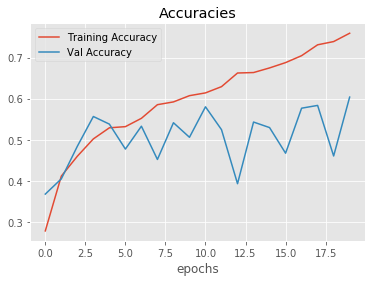

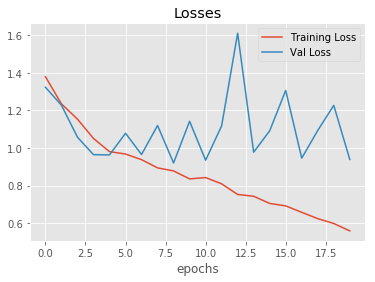

In [83]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)
#print(model.summary())
model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=20,validation_split=0.25,batch_size=32,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=32)
print "Test Results are ", test_score
    
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

### C-DRNN Testing

Train on 15810 samples, validate on 5270 samples
Epoch 1/20
15810/15810 [==============================] - 133s 8ms/step - loss: 1.3784 - acc: 0.2832 - val_loss: 1.6776 - val_acc: 0.2512
Epoch 2/20
15810/15810 [==============================] - 130s 8ms/step - loss: 1.3139 - acc: 0.3583 - val_loss: 1.4438 - val_acc: 0.3032
Epoch 3/20
15810/15810 [==============================] - 129s 8ms/step - loss: 1.2611 - acc: 0.4066 - val_loss: 1.4585 - val_acc: 0.3381
Epoch 4/20
15810/15810 [==============================] - 130s 8ms/step - loss: 1.2071 - acc: 0.4343 - val_loss: 1.4595 - val_acc: 0.3634
Epoch 5/20
15810/15810 [==============================] - 130s 8ms/step - loss: 1.1566 - acc: 0.4703 - val_loss: 1.3643 - val_acc: 0.3964
Epoch 6/20
15810/15810 [==============================] - 130s 8ms/step - loss: 1.1030 - acc: 0.5017 - val_loss: 1.3127 - val_acc: 0.4326
Epoch 7/20
15810/15810 [==============================] - 130s 8ms/step - loss: 1.0539 - acc: 0.5279 - val_loss: 1.9397 - v

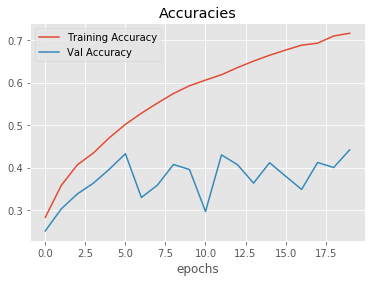

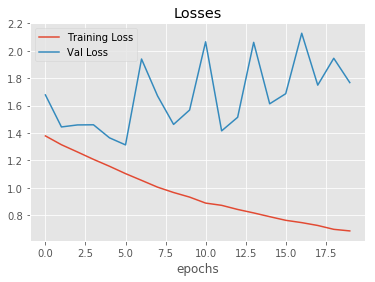

In [33]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D,BatchNormalization,Dropout
from keras.models import Model

inputs= Input(shape=(t,f))

x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
x = BatchNormalization()(x)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = BatchNormalization()(x)
x = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
x = Dropout(0.5)(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=20,validation_split=0.25,batch_size=32,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=32)
print "Test Results are ", test_score
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
test_predict = model.predict(test_data_sliced, batch_size=16)

#conf = []
#test_score = []

#for i in range(9):
#    print "Subject {}".format(i+1)
#    test_score_i = model.evaluate(test_data_all[i], test_labels_all[i], batch_size=64)
#    print "Test Score: {}".format(test_score_i)
#    test_predict = model.predict(test_data_all[i], batch_size=16)
#    cm = confusion_matrix(np.argmax(test_labels_all[i],axis=1),np.argmax(test_predict,axis=1))
#    conf.append(cm)
#    test_score.append(test_score_i)

plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


In [34]:
#np.save('Best Models/Variables/CRDNN_hist_All',hist.history)
#np.save('Best Models/Variables/CRDNN_testacc_All',test_score)
#np.save('Best Models/Variables/CRDNN_conf_All',conf)

## ChronoNet

Train on 1777 samples, validate on 593 samples
Epoch 1/10
1777/1777 [==============================] - 24s 14ms/step - loss: 1.4201 - acc: 0.2487 - val_loss: 1.3753 - val_acc: 0.2968
Epoch 2/10
1777/1777 [==============================] - 8s 4ms/step - loss: 1.3475 - acc: 0.3343 - val_loss: 1.3522 - val_acc: 0.2732
Epoch 3/10
1777/1777 [==============================] - 8s 4ms/step - loss: 1.2141 - acc: 0.4237 - val_loss: 1.1789 - val_acc: 0.4553
Epoch 4/10
1777/1777 [==============================] - 8s 4ms/step - loss: 1.0286 - acc: 0.5346 - val_loss: 1.0001 - val_acc: 0.5278
Epoch 5/10
1777/1777 [==============================] - 8s 4ms/step - loss: 0.9063 - acc: 0.5841 - val_loss: 1.0072 - val_acc: 0.5093
Epoch 6/10
1777/1777 [==============================] - 8s 4ms/step - loss: 0.8369 - acc: 0.6398 - val_loss: 0.9714 - val_acc: 0.5278
Epoch 7/10
1777/1777 [==============================] - 8s 4ms/step - loss: 0.7677 - acc: 0.6742 - val_loss: 1.0621 - val_acc: 0.5413
Epoch 8/10
17

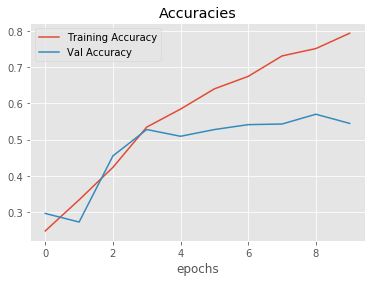

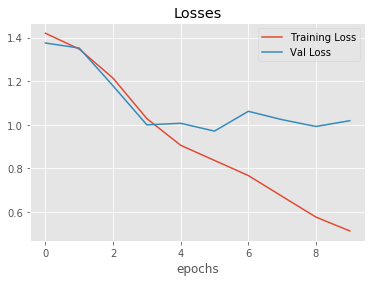

In [86]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
x = concatenate([tower1,tower2,tower3],axis=2)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
x = concatenate([tower1,tower2,tower3],axis=2)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'rmsprop',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=10,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)

print "Testing Accuracy is", test_score
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')


### ChronoNet Model Testing

Train on 1777 samples, validate on 593 samples
Epoch 1/100
1777/1777 [==============================] - 14s 8ms/step - loss: 1.4176 - acc: 0.2515 - val_loss: 1.3935 - val_acc: 0.2631
Epoch 2/100
1777/1777 [==============================] - 11s 6ms/step - loss: 1.3897 - acc: 0.2741 - val_loss: 1.3783 - val_acc: 0.2901
Epoch 3/100
1777/1777 [==============================] - 11s 6ms/step - loss: 1.3603 - acc: 0.3123 - val_loss: 1.3268 - val_acc: 0.3153
Epoch 4/100
1777/1777 [==============================] - 11s 6ms/step - loss: 1.3249 - acc: 0.3410 - val_loss: 1.2999 - val_acc: 0.3693
Epoch 5/100
1777/1777 [==============================] - 11s 6ms/step - loss: 1.1989 - acc: 0.4254 - val_loss: 1.2876 - val_acc: 0.4283
Epoch 6/100
1777/1777 [==============================] - 11s 6ms/step - loss: 1.0160 - acc: 0.5076 - val_loss: 1.2351 - val_acc: 0.4604
Epoch 7/100
1777/1777 [==============================] - 11s 6ms/step - loss: 0.9761 - acc: 0.5031 - val_loss: 1.0504 - val_acc: 0.5059
E

1777/1777 [==============================] - 11s 6ms/step - loss: 0.0604 - acc: 0.9792 - val_loss: 2.1129 - val_acc: 0.5363
Epoch 61/100
1777/1777 [==============================] - 11s 6ms/step - loss: 0.0568 - acc: 0.9803 - val_loss: 2.2372 - val_acc: 0.5278
Epoch 62/100
1777/1777 [==============================] - 11s 6ms/step - loss: 0.0774 - acc: 0.9752 - val_loss: 1.5285 - val_acc: 0.6476
Epoch 63/100
1777/1777 [==============================] - 11s 6ms/step - loss: 0.0913 - acc: 0.9702 - val_loss: 1.9595 - val_acc: 0.5481
Epoch 64/100
1777/1777 [==============================] - 11s 6ms/step - loss: 0.0995 - acc: 0.9645 - val_loss: 1.7090 - val_acc: 0.5902
Epoch 65/100
1777/1777 [==============================] - 11s 6ms/step - loss: 0.0684 - acc: 0.9803 - val_loss: 1.7943 - val_acc: 0.5784
Epoch 66/100
1777/1777 [==============================] - 11s 6ms/step - loss: 0.0551 - acc: 0.9837 - val_loss: 1.7052 - val_acc: 0.6054
Epoch 67/100
1777/1777 [==============================

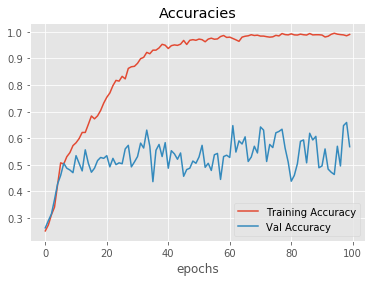

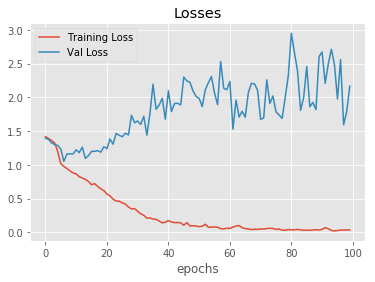

In [33]:
from keras.layers import Input,Dense,concatenate,Flatten,GRU,Conv1D
from keras.models import Model

ind = np.random.choice(train_data_sliced.shape[0],5000)
inputs= Input(shape=(t,f))

# First Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(inputs)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(inputs)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(inputs)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.45)(x)

# Second Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.45)(x)

# Third Inception
tower1 = Conv1D(32, 2, strides=2,activation='relu',padding="causal")(x)
tower1 = BatchNormalization()(tower1)
tower2 = Conv1D(32, 4, strides=2,activation='relu',padding="causal")(x)
tower2 = BatchNormalization()(tower2)
tower3 = Conv1D(32, 8, strides=2,activation='relu',padding="causal")(x)
tower3 = BatchNormalization()(tower3)
x = concatenate([tower1,tower2,tower3],axis=2)
x = Dropout(0.55)(x)

res1 = GRU(32,activation='tanh',return_sequences=True)(x)
res2 = GRU(32,activation='tanh',return_sequences=True)(res1)

res1_2 = concatenate([res1,res2],axis=2)

res3 = GRU(32,activation='tanh',return_sequences=True)(res1_2)

x = concatenate([res1,res2,res3])

x = GRU(32,activation='tanh')(x)
predictions = Dense(4,activation='softmax')(x)

model = Model(inputs=inputs, outputs=predictions)

model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics=['accuracy'])

#hist.history is a dictionary with all accs and losses
hist = model.fit(train_data_sliced,train_labels_sliced,epochs=100,validation_split=0.25,batch_size=64,verbose=1)
test_score = model.evaluate(test_data_sliced, test_labels_sliced, batch_size=64)
print "Testing Accuracy is", test_score
cm = confusion_matrix(np.argmax(test_labels_sliced,axis=1),np.argmax(test_predict,axis=1))
test_predict = model.predict(test_data_sliced, batch_size=16)

#conf = []
#test_score = []

#for i in range(9):
#    print "Subject {}".format(i+1)
#    test_score_i = model.evaluate(test_data_all[i], test_labels_all[i], batch_size=64)
#    print "Test Score: {}".format(test_score_i)
#    test_predict = model.predict(test_data_all[i], batch_size=16)
#    cm = confusion_matrix(np.argmax(test_labels_all[i],axis=1),np.argmax(test_predict,axis=1))
#    conf.append(cm)
#    test_score.append(test_score_i)
    
plot_hist([hist.history['acc'],hist.history['val_acc']],['Training Accuracy','Val Accuracy'],title='Accuracies')
plot_hist([hist.history['loss'],hist.history['val_loss']],['Training Loss','Val Loss'],title='Losses')

In [34]:
np.save('Best Models/Variables/ChronoNet_hist_A10T-750',hist.history)
np.save('Best Models/Variables/ChronoNet_testacc_A10T-750',test_score)
np.save('Best Models/Variables/ChronoNet_conf_A01T-750',conf)